# Maximizing conversion rates and profit of an e-shop company with additional physical stores

## Business Challenge

The company is sending promotional offers / incentives to its customers. They are sending them either via personalized emails or generic app notifications. Due to time capacity of the staff only 30% of the offers / incentives are sent via personalized emails. The remaining 70% of the offers / incentives are handled by automated generic e-shop app notifications. Currently, the selection of the customers who receive their offers / incentives via personalized emails or generic app notifications is random.
The management team has observed that customers who receive offers / incentives via personalized emails have a higher conversion rate compared to those who are sent offers / incentives via generic app notifications. However, they also recognize that not all customers or products yield the same profits or have the same likelihood of conversion.
The company wants to optimize the selection of the customers who will receive their offers / incentives via personalized emails and who will receive their offers / incentives via generic app notifications in order to maximize profits.

## Available Data

### Core Data

- Customer_ID: unique id representing a customer
- Chain: integer representing a store chain
- Gender: gender of the customer
- Offer_ID: id representing a certain offer
- Market: id representing a geographical region
- Previous_Interactions: number of previous interactions with the company
- Brand: brand of the product
- Sales_Price: price of the product
- Purchase_Price: acquisition price of the product for which the company has bought the item
- Sales_Expense: additional expenses associated with the sale (e.g., shipping, handling)
- Offer_Incentive_Sent_Via: channel through which the offer was sent (personalized email or generic app notification)
- Channel: channel through which the customer interacted with the company while asking additional questions about the order
- Conversion: whether the customer bought the product or not
- Preferred_Channel: channel through which the customer prefers to interact with the company while asking additional questions about the order
- Profit: profit made from the sale (= Sales_Price - Purchase_Price - Sales_Expense)

### Competition Data

- Customer_ID: unique id representing a customer (id to be mapped on a unique customer in core data)
- Competitor_Price: price of the product from a competitor
- Price_Difference: difference between the price of the product and the price of the same product from a competitor

## Objectives

- think about reasonable strategies and about the fact that if you want to improve something, you must first define an evaluation / objective function that you want to improve / optimize or define a performance indicator
- given the evaluation / objective function, you should come up with the ML solution of what you need to solve
- set up the propensity / classification model to select clients with the highest conversion rate (propensity to buy)
- evaluate the model and present the results
- take into account lift curves and check the correctness of the previous evaluation
- correct evaluation if necessary
- incorporate the optimization of the profit in the solution
- present the solution and the results and compare them among different teams
- take into account also the prices of the competitors and try to come up with a solution to incorporate them into the model definition, evaluation / objective function, optimization strategies

In [1]:
from pathlib import Path
import threading
import joblib
import logging
import warnings
from typing import Dict, List, Tuple, Any, Callable, Optional, TypedDict, ClassVar
from abc import ABC, abstractmethod
from dataclasses import dataclass
import time
from functools import wraps

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import classification_report, roc_auc_score, brier_score_loss
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from xgboost import XGBClassifier

In [2]:
LOGGING_CONFIG = {
    "version": 1,
    "disable_existing_loggers": False,
    "formatters": {
        "standard": {"format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s"},
        "detailed": {
            "format": "%(asctime)s - %(name)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s"
        },
    },
    "handlers": {
        "console": {
            "level": "INFO",
            "formatter": "standard",
            "class": "logging.StreamHandler",
        },
        "file": {
            "level": "DEBUG",
            "formatter": "detailed",
            "class": "logging.FileHandler",
            "filename": "app.log",
            "mode": "a",
        },
    },
    "loggers": {
        "": {"handlers": ["console", "file"], "level": "INFO", "propagate": False},
    },
}

In [3]:
logging.config.dictConfig(LOGGING_CONFIG)
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
random.seed(hash("abc") % 2**32 - 1)
np.random.seed(hash("xyz") % 2**32 - 1)

In [4]:
class BlockTimer:
    """
    A context manager class for timing code blocks.
    """

    def __init__(self, name: str):
        self.name = name
        self.start_time: Optional[float] = None

    def __enter__(self):
        self.start_time = time.time()
        logging.info(f"Starting {self.name}")
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        elapsed_time = time.time() - self.start_time
        logging.info(f"{self.name} - elapsed time: {elapsed_time:.2f}s")

In [5]:
def method_timer(method: Callable[..., Any]) -> Callable[..., Any]:
    """
    Decorator to measure the execution time of methods.
    """

    @wraps(method)
    def wrapper(self: Any, *args: Any, **kwargs: Any) -> Any:
        start_time = time.time()
        result = method(self, *args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        logger = logging.getLogger(self.__class__.__name__)
        logger.info(f"Method {method.__name__} executed in {elapsed_time:.2f}s")
        return result

    return wrapper

In [6]:
def log_method_call(method: Callable[..., Any]) -> Callable[..., Any]:
    """
    Decorator to log method calls.
    """

    @wraps(method)
    def wrapper(self: Any, *args: Any, **kwargs: Any) -> Any:
        logger = logging.getLogger(self.__class__.__name__)
        logger.info(f"Called method {method.__name__}")
        return method(self, *args, **kwargs)

    return wrapper

In [7]:
class SingletonMeta(type):
    """
    Thread-safe implementation of Singleton.
    """

    _instance: Optional["SingletonMeta"] = None
    _lock: threading.Lock = threading.Lock()

    def __call__(cls, *args, **kwargs):
        with cls._lock:
            if cls._instance is None:
                cls._instance = super().__call__(*args, **kwargs)
        return cls._instance

In [8]:
class DataProcessingError(Exception):
    """
    Exception raised for errors in the data processing pipeline.
    """

    pass

In [9]:
class ModelTrainingError(Exception):
    """
    Exception raised for errors during model training.
    """

    pass

In [10]:
class ModelEvaluationError(Exception):
    """
    Exception raised for errors during model training.
    """

    pass

In [11]:
def load_data(*, file_path: str, version: str = None) -> pd.DataFrame:
    """
    Load data from a CSV file, optionally loading a specific version.

    Args:
        file_path (str): Path to the data file.
        version (str, optional): Specific version identifier of the data.

    Returns:
        pd.DataFrame: Loaded data.
    """
    if version:
        file_path = f"{file_path}_v{version}.csv"
    else:
        file_path = f"{file_path}.csv"
    try:
        data = pd.read_csv(file_path)
        logging.info(f"Data loaded from {file_path}")
        return data
    except FileNotFoundError as e:
        logging.error(f"Data file not found: {file_path}")
        raise e

In [12]:
data = load_data(file_path="dataset", version="3")
competition_data = load_data(file_path="competition_data", version=None)
data = pd.merge(data, competition_data, on="Customer_ID", how="inner")

2024-11-25 15:32:59,351 - root - INFO - Data loaded from dataset_v3.csv
2024-11-25 15:32:59,355 - root - INFO - Data loaded from competition_data.csv


In [13]:
class ConversionRateAnalyzer:
    """
    A class to analyze and visualize the conversion rates and profits.
    """

    def __init__(self, data: pd.DataFrame) -> None:
        """
        Initialize the DataAnalyzer with the dataset.

        Args:
            data (pd.DataFrame): The dataset to analyze.
        """
        self.data = data
        self.logger = logging.getLogger(self.__class__.__name__)
        return None

    @log_method_call
    def analyze_conversion_rates(self) -> None:
        """
        Analyze and visualize conversion rates by Offer_Incentive_Sent_Via.
        """
        conversion_rates = self.data.groupby("Offer_Incentive_Sent_Via")[
            "Conversion"
        ].mean()
        print("Conversion Rates by Offer_Incentive_Sent_Via:")
        print(conversion_rates)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
        plt.title("Conversion Rates by Offer_Incentive_Sent_Via")
        plt.ylabel("Conversion Rate")
        plt.show()
        return None

    @log_method_call
    def analyze_profit_by_response(self) -> None:
        """
        Analyze and visualize total profit by Offer_Incentive_Sent_Via.
        """
        profit_by_response = self.data.groupby("Offer_Incentive_Sent_Via")[
            "Profit"
        ].sum()
        print("\nTotal Profit by Offer_Incentive_Sent_Via:")
        print(profit_by_response)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=profit_by_response.index, y=profit_by_response.values)
        plt.title("Total Profit by Offer_Incentive_Sent_Via")
        plt.ylabel("Total Profit")
        plt.show()
        return None

    @log_method_call
    def analyze_product_conversion_rates(self) -> None:
        """
        Analyze and visualize conversion rates by Offer_Incentive_Sent_Via and Brand.
        """
        product_conversion_rates = (
            self.data.groupby(["Offer_Incentive_Sent_Via", "Brand"])["Conversion"]
            .mean()
            .unstack()
        )
        print("\nConversion Rates by Offer_Incentive_Sent_Via and Brand:")
        print(product_conversion_rates)

        plt.figure(figsize=(12, 6))
        sns.heatmap(product_conversion_rates, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title("Conversion Rates by Offer_Incentive_Sent_Via and Brand")
        plt.show()
        return None

    @log_method_call
    def analyze_income_conversion_rates(self) -> None:
        """
        Analyze and visualize conversion rates by Offer_Incentive_Sent_Via and Offer_ID.
        """
        income_conversion_rates = (
            self.data.groupby(["Offer_Incentive_Sent_Via", "Offer_ID"])["Conversion"]
            .mean()
            .unstack()
        )
        print("\nConversion Rates by Offer_Incentive_Sent_Via and Offer_ID:")
        print(income_conversion_rates)

        plt.figure(figsize=(12, 6))
        sns.heatmap(income_conversion_rates, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title("Conversion Rates by Offer_Incentive_Sent_Via and Offer_ID")
        plt.show()
        return None

    @log_method_call
    def run_all(self) -> None:
        """
        Run all analysis methods in sequence.
        """
        self.analyze_conversion_rates()
        self.analyze_profit_by_response()
        self.analyze_product_conversion_rates()
        self.analyze_income_conversion_rates()
        return None

2024-11-25 15:32:59,372 - ConversionRateAnalyzer - INFO - Called method run_all
2024-11-25 15:32:59,372 - ConversionRateAnalyzer - INFO - Called method analyze_conversion_rates


Conversion Rates by Offer_Incentive_Sent_Via:
Offer_Incentive_Sent_Via
Generic_App_Notification   0.03757
Personalized_Email         0.39033
Name: Conversion, dtype: float64


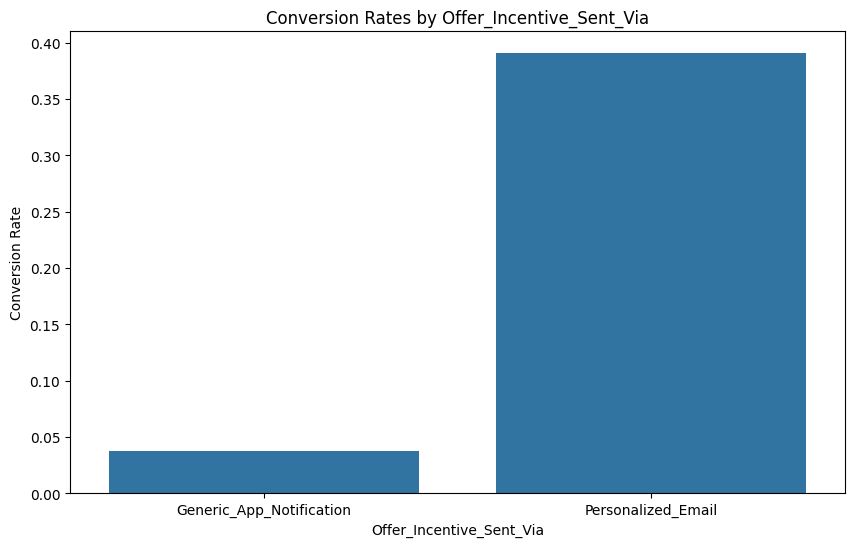

2024-11-25 15:32:59,465 - ConversionRateAnalyzer - INFO - Called method analyze_profit_by_response



Total Profit by Offer_Incentive_Sent_Via:
Offer_Incentive_Sent_Via
Generic_App_Notification   40249004.80537
Personalized_Email         16591663.44731
Name: Profit, dtype: float64


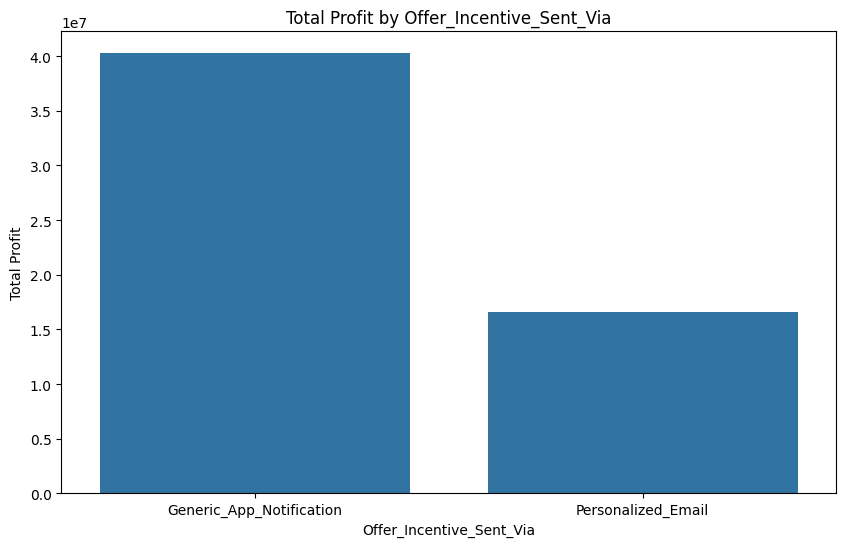

2024-11-25 15:32:59,513 - ConversionRateAnalyzer - INFO - Called method analyze_product_conversion_rates



Conversion Rates by Offer_Incentive_Sent_Via and Brand:
Brand                     Brand1  Brand2  Brand3  Brand4
Offer_Incentive_Sent_Via                                
Generic_App_Notification 0.03699 0.04308 0.04504 0.02493
Personalized_Email       0.39232 0.39378 0.39972 0.37629


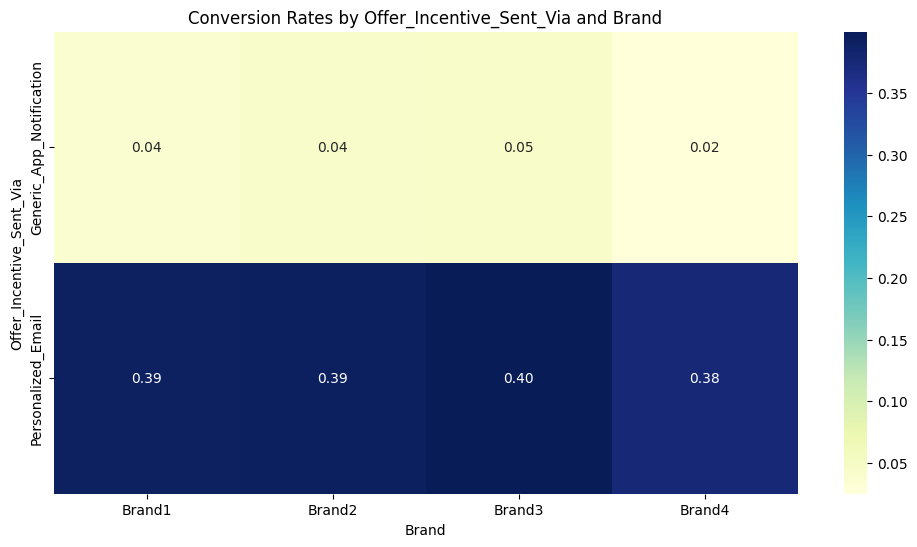

2024-11-25 15:32:59,576 - ConversionRateAnalyzer - INFO - Called method analyze_income_conversion_rates



Conversion Rates by Offer_Incentive_Sent_Via and Offer_ID:
Offer_ID                  Offer1  Offer2  Offer3
Offer_Incentive_Sent_Via                        
Generic_App_Notification 0.11380 0.00000 0.00000
Personalized_Email       0.74823 0.20662 0.21895


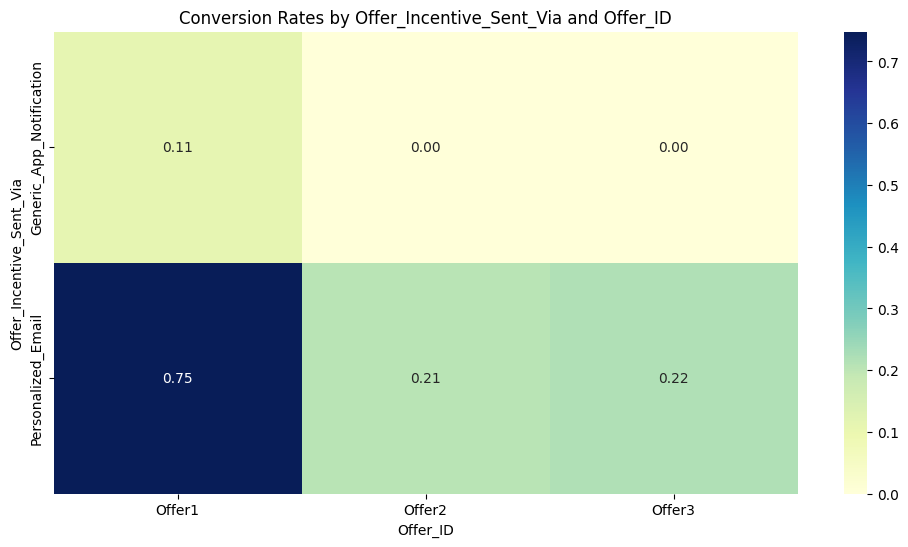

In [14]:
analyzer = ConversionRateAnalyzer(data)
analyzer.run_all()

In [15]:
@dataclass(frozen=True)
class DataPreprocessorConfig(metaclass=SingletonMeta):
    """
    Configuration class for DataPreprocessor.
    """

    FEATURES: ClassVar[List[str]] = [
        "Chain",
        "Gender",
        "Offer_ID",
        "Market",
        "Previous_Interactions",
        "Brand",
        "Sales_Price",
        "Channel",
        "Price_Difference",
        "Competitor_Price",
    ]
    CATEGORICAL_FEATURES: ClassVar[List[str]] = [
        "Gender",
        "Offer_ID",
        "Market",
        "Brand",
        "Channel",
        "Preferred_Channel",
        "Offer_Incentive_Sent_Via",
    ]
    NUMERICAL_FEATURES: ClassVar[List[str]] = [
        "Chain",
        "Previous_Interactions",
        "Sales_Price",
        "Price_Difference",
    ]

In [16]:
class DataPreprocessor:
    """
    A class to preprocess the dataset.
    """

    def __init__(self, data: pd.DataFrame, resample: bool = True) -> None:
        """
        Initialize the DataPreprocessor with the dataset.

        Args:
            data (pd.DataFrame): The dataset to preprocess.
        """
        self.data = data
        self.features = DataPreprocessorConfig.FEATURES
        self.categorical_features = DataPreprocessorConfig.CATEGORICAL_FEATURES
        self.numerical_features = DataPreprocessorConfig.NUMERICAL_FEATURES
        self.resample = resample
        self.logger = logging.getLogger(self.__class__.__name__)
        self._X: Optional[pd.DataFrame] = None
        self._y: Optional[pd.Series] = None
        self._cache: Dict[str, Any] = {}
        return None

    @log_method_call
    def encode_categorical_features(self) -> pd.DataFrame:
        """
        Encode categorical features using one-hot encoding.

        Returns:
            pd.DataFrame: The dataset with encoded categorical features.
        """
        try:
            encoded_data = pd.get_dummies(
                self.data, columns=self.categorical_features, drop_first=True
            )
            return encoded_data
        except Exception as e:
            self.logger.error("Error encoding categorical features")
            raise DataProcessingError(e) from e

    @log_method_call
    def get_feature_columns(self, data_encoded: pd.DataFrame) -> List[str]:
        """
        Get the list of feature columns, including dummy variables.

        Args:
            data_encoded (pd.DataFrame): The encoded dataset.

        Returns:
            List[str]: List of feature column names.
        """
        try:
            dummy_columns = [
                col
                for col in data_encoded.columns
                if any(cat in col for cat in self.categorical_features)
            ]
            return self.numerical_features + dummy_columns
        except Exception as e:
            self.logger.error("Error getting feature columns")
            raise DataProcessingError(e) from e

    @log_method_call
    def prepare_data(self) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Prepare the data by encoding categorical features
        and selecting relevant columns.

        Returns:
            Tuple[pd.DataFrame, pd.Series]: Features (X) and target variable (y).
        """
        try:
            cache_key = "prepare_data"
            if cache_key in self._cache:
                self.logger.info("Using cached processed data.")
                return self._cache[cache_key]

            data_encoded = self.encode_categorical_features()
            feature_columns = self.get_feature_columns(data_encoded)
            X = data_encoded[feature_columns]
            y = data_encoded["Conversion"]

            self._cache[cache_key] = (X, y)
            return X, y
        except Exception as e:
            self.logger.error("Error preparing data")
            raise DataProcessingError(e) from e

    @log_method_call
    def split_data(
        self, test_size: float = 0.3, random_state: int = 42
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
        """
        Split the data into training and testing sets.

        Args:
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducibility.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]: X_train, X_test, y_train, y_test
        """
        try:
            X, y = self.prepare_data()
            if self.resample:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=test_size, stratify=y, random_state=random_state
                )
                train_data = X_train.copy()
                train_data["Conversion"] = y_train
                minority_class = train_data[train_data["Conversion"] == 1]
                majority_class = train_data[train_data["Conversion"] == 0]
                minority_cnt = len(minority_class)
                self.logger.info(f"Minority class count: {minority_cnt}")
                majority_class_sampled = majority_class.sample(
                    n=minority_cnt, random_state=random_state
                )
                balanced_train_data = pd.concat(
                    [minority_class, majority_class_sampled]
                )
                balanced_train_data = balanced_train_data.sample(
                    frac=1, random_state=random_state
                ).reset_index(drop=True)
                X_train = balanced_train_data.drop("Conversion", axis=1)
                y_train = balanced_train_data["Conversion"]
            else:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=test_size, stratify=y, random_state=random_state
                )
            return X_train, X_test, y_train, y_test
        except Exception as e:
            self.logger.error("Error splitting data")
            raise DataProcessingError(e) from e

In [17]:
preprocessor = DataPreprocessor(data, resample=True)
X_train, X_test, y_train, y_test = preprocessor.split_data()

2024-11-25 15:32:59,649 - DataPreprocessor - INFO - Called method split_data
2024-11-25 15:32:59,650 - DataPreprocessor - INFO - Called method prepare_data
2024-11-25 15:32:59,650 - DataPreprocessor - INFO - Called method encode_categorical_features
2024-11-25 15:32:59,654 - DataPreprocessor - INFO - Called method get_feature_columns
2024-11-25 15:32:59,658 - DataPreprocessor - INFO - Minority class count: 1004


In [18]:
class BaseTrainer(ABC):
    """
    Abstract base class for model training.
    """

    @abstractmethod
    def train_models(self):
        """
        Train models.
        """
        pass

    @abstractmethod
    def _evaluate_model(self, model: BaseEstimator) -> Dict[str, Any]:
        """
        Evaluate a trained model.
        """
        pass

In [19]:
class ModelEvaluationResult(TypedDict):
    """
    Result of model evaluation.
    """

    classification_report: str
    roc_auc_score: float
    brier_score: float
    expected_profit: float
    y_pred: np.ndarray
    y_pred_proba: np.ndarray

In [20]:
class ModelTrainer(BaseTrainer):
    """
    A class to train and evaluate multiple classification models.
    """

    def __init__(
        self,
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.Series,
        y_test: pd.Series,
    ) -> None:
        """
        Initialize the ModelTrainer with training and testing data.

        Args:
            X_train (pd.DataFrame): Training features
            X_test (pd.DataFrame): Testing features
            y_train (pd.Series): Training labels
            y_test (pd.Series): Testing labels
        """
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.models = {}
        self.results = {}
        self.logger = logging.getLogger(self.__class__.__name__)
        return None

    @staticmethod
    def initialize_models(random_state: int = 42) -> Dict[str, BaseEstimator]:
        """
        Initialize models to be trained.

        Args:
            random_state (int): Random state for reproducibility

        Returns:
            Dict[str, BaseEstimator]: Dictionary of model instances
        """
        return {
            "RandomForest": RandomForestClassifier(random_state=random_state),
            "XGBoost": XGBClassifier(
                random_state=random_state,
                eval_metric="logloss",
            ),
        }

    @staticmethod
    def get_param_distributions() -> Dict[str, Dict[str, Any]]:
        """
        Define hyperparameter search spaces for each model.

        Returns:
            Dict[str, Dict[str, Any]]: Dictionary of parameter distributions for each model
        """
        return {
            "RandomForest": {
                "n_estimators": [100, 200, 300, 400, 500],
                "max_depth": [None, 10, 20, 30, 40, 50],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
                "max_features": ["sqrt", "log2", None],
                "class_weight": ["balanced", "balanced_subsample", None],
            },
            "XGBoost": {
                "n_estimators": [100, 200, 300, 400, 500],
                "max_depth": [3, 4, 5, 6, 7, 8],
                "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
                "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
                "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
                "min_child_weight": [1, 3, 5, 7],
                "gamma": [0, 0.1, 0.2, 0.3, 0.4],
            },
        }

    @log_method_call
    @method_timer
    def train_models(self, random_state: int = 42) -> None:
        """
        Train models with hyperparameter optimization using RandomizedSearchCV.

        Args:
            random_state (int): Random state for reproducibility
        """
        try:
            param_distributions = self.get_param_distributions()
            self.models = {}
            self.best_params = {}
            
            for name, base_model in self.initialize_models(random_state).items():
                self.logger.info(f"Training {name} with hyperparameter optimization")
                
                search = RandomizedSearchCV(
                    estimator=base_model,
                    param_distributions=param_distributions[name],
                    n_iter=20,
                    cv=5,
                    scoring="roc_auc",
                    n_jobs=-1,
                    random_state=random_state,
                    verbose=1,
                )
                
                search.fit(self.X_train, self.y_train)
                
                self.models[name] = search.best_estimator_
                self.best_params[name] = search.best_params_
                self.logger.info(f"Best parameters for {name}: {search.best_params_}")
                self.logger.info(f"Best cross-validation score for {name}: {search.best_score_:.4f}")
                self.results[name] = self._evaluate_model(search.best_estimator_)
            return None
        except Exception as e:
            self.logger.error("Error during model training and optimization")
            raise ModelTrainingError(e) from e

    @log_method_call
    @method_timer
    def _evaluate_model(self, model: BaseEstimator) -> ModelEvaluationResult:
        """
        Evaluate a trained model and return performance metrics.

        Args:
            model (BaseEstimator): Trained sklearn-compatible model

        Returns:
            Dict[str, Any]: Dictionary containing evaluation metrics
        """
        try:
            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]

            return {
                "classification_report": classification_report(self.y_test, y_pred),
                "roc_auc_score": roc_auc_score(self.y_test, y_pred_proba),
                "y_pred": y_pred,
                "y_pred_proba": y_pred_proba,
            }
        except Exception as e:
            self.logger.error("Error evaluating model")
            raise ModelEvaluationError(e) from e


    @log_method_call
    def print_results(self):
        """
        Print optimization results and model performance metrics.
        """
        for name in self.models:
            print(f"\n--- {name} Results ---")
            print(f"Best Parameters: {self.best_params[name]}")
            print("\nTest Set Performance:")
            print(self.results[name]["classification_report"])
            print(f"ROC AUC Score: {self.results[name]['roc_auc_score']:.4f}")

    @log_method_call
    def plot_calibration_curves(self):
        """
        Plot calibration curves for all trained models.
        """
        plt.figure(figsize=(12, 8))
        for name, model in self.models.items():
            CalibrationDisplay.from_estimator(
                model, self.X_test, self.y_test, n_bins=10, name=name
            )
        plt.title("Calibration Curves")
        plt.legend()
        plt.show()

    @log_method_call
    def plot_lift_curves(self):
        """
        Plot lift curves for all trained models.
        """
        plt.figure(figsize=(12, 8))
        for name, result in self.results.items():
            self._plot_single_lift_curve(self.y_test, result["y_pred_proba"], name)
        plt.title("Lift Curves")
        plt.legend()
        plt.show()

    @staticmethod
    def _plot_single_lift_curve(
        y_true: np.ndarray, y_scores: np.ndarray, model_name: str
    ):
        """
        Plot a lift curve for a single model.

        Args:
            y_true (np.ndarray): True labels
            y_scores (np.ndarray): Predicted probabilities
            model_name (str): Name of the model for the legend
        """
        data = pd.DataFrame({"y_true": y_true, "y_scores": y_scores})
        data.sort_values("y_scores", ascending=False, inplace=True)

        data["cum_true"] = data["y_true"].cumsum()
        data["lift"] = data["cum_true"] / data["y_true"].sum()
        data["baseline"] = np.arange(1, len(data) + 1) / len(data)

        plt.plot(data["lift"].values, label=f"{model_name} Lift Curve")
        plt.plot(data["baseline"].values, label="Baseline", linestyle="--")
        plt.xlabel("Percentage of Sample")
        plt.ylabel("Percentage of Positive Outcomes")

    @log_method_call
    def get_best_model(self, metric: str = "roc_auc_score") -> str:
        """
        Get the name of the best performing model based on a specified metric.

        Args:
            metric (str): Metric to use for comparison (default is 'roc_auc_score')

        Returns:
            str: Name of the best performing model
        """
        return max(self.results, key=lambda x: self.results[x][metric])

    @log_method_call
    def save_models(self, directory: str = "models") -> None:
        """
        Saves each model in the `models` dictionary to the specified directory using `joblib`.
        The models are saved with filenames in the format `{model_name}_model.joblib`.

        Args:
            directory (str, optional): The directory where models will be saved. Defaults to `"models"`.

        Returns:
            None
        """
        directory_path = Path(directory)
        directory_path.mkdir(parents=True, exist_ok=True)
        for name, model in self.models.items():
            filename = directory_path / f"{name}_model.joblib"
            joblib.dump(model, filename)
            self.logger.info(f"Model {name} saved to {filename}")
        return None

    @log_method_call
    def load_models(self, directory: str = "models") -> None:
        """
        Loads models from the specified directory into the `models` dictionary.
        It expects model files with filenames in the format `{model_name}_model.joblib`.

        Args:
            directory (str, optional): The directory from which models will be loaded. Defaults to `"models"`.

        Returns:
            None
        """
        directory_path = Path(directory)
        self.models = {}
        for filepath in directory_path.glob("*_model.joblib"):
            name = filepath.stem.replace("_model", "")
            model = joblib.load(filepath)
            self.models[name] = model
            self.logger.info(f"Model {name} loaded from {filepath}")
        return None

    @log_method_call
    def run_all(self) -> None:
        """
        Run all steps: train models with optimization, print results, and plot curves.
        """
        self.train_models()
        self.print_results()
        self.plot_calibration_curves()
        self.plot_lift_curves()
        self.save_models()
        best_model = self.get_best_model()
        print(f"\nBest model based on ROC AUC score: {best_model}")
        return None

2024-11-25 15:32:59,678 - root - INFO - Starting Model training and evaluation
2024-11-25 15:32:59,679 - ModelTrainer - INFO - Called method train_models
2024-11-25 15:32:59,679 - ModelTrainer - INFO - Training RandomForest with hyperparameter optimization


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2024-11-25 15:33:05,222 - ModelTrainer - INFO - Best parameters for RandomForest: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': None}
2024-11-25 15:33:05,223 - ModelTrainer - INFO - Best cross-validation score for RandomForest: 0.9988
2024-11-25 15:33:05,223 - ModelTrainer - INFO - Called method _evaluate_model
2024-11-25 15:33:05,308 - ModelTrainer - INFO - Method _evaluate_model executed in 0.08s
2024-11-25 15:33:05,308 - ModelTrainer - INFO - Training XGBoost with hyperparameter optimization


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2024-11-25 15:33:06,134 - ModelTrainer - INFO - Best parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 1.0}
2024-11-25 15:33:06,136 - ModelTrainer - INFO - Best cross-validation score for XGBoost: 0.9988
2024-11-25 15:33:06,136 - ModelTrainer - INFO - Called method _evaluate_model
2024-11-25 15:33:06,144 - ModelTrainer - INFO - Method _evaluate_model executed in 0.01s
2024-11-25 15:33:06,145 - ModelTrainer - INFO - Method train_models executed in 6.47s
2024-11-25 15:33:06,145 - ModelTrainer - INFO - Called method print_results
2024-11-25 15:33:06,146 - ModelTrainer - INFO - Called method plot_calibration_curves



--- RandomForest Results ---
Best Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': None}

Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2570
           1       0.94      0.98      0.96       430

    accuracy                           0.99      3000
   macro avg       0.97      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000

ROC AUC Score: 0.9987

--- XGBoost Results ---
Best Parameters: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 1.0}

Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2570
           1       0.93      0.98      0.95       430

    accuracy                           0.99      3000
   macro avg       0.96 

<Figure size 1200x800 with 0 Axes>

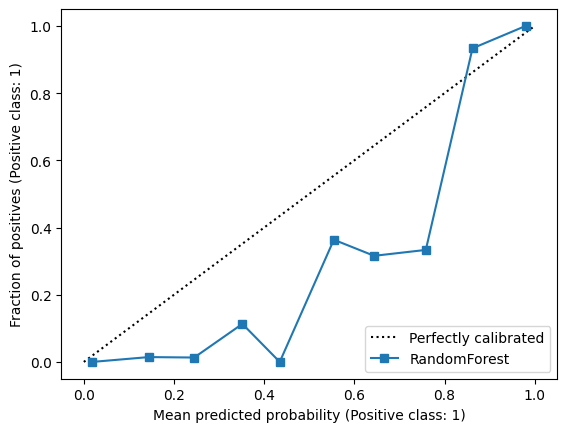

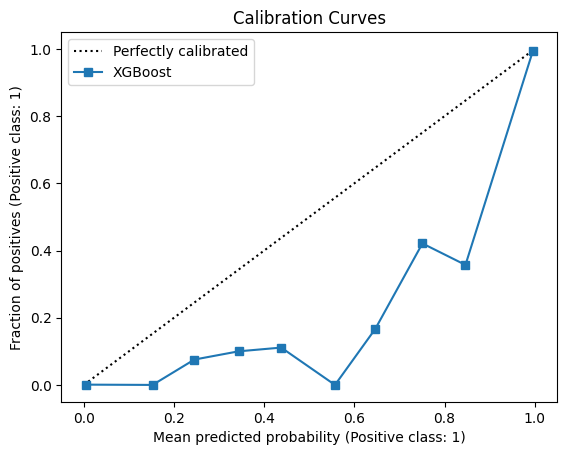

2024-11-25 15:33:06,288 - ModelTrainer - INFO - Called method plot_lift_curves


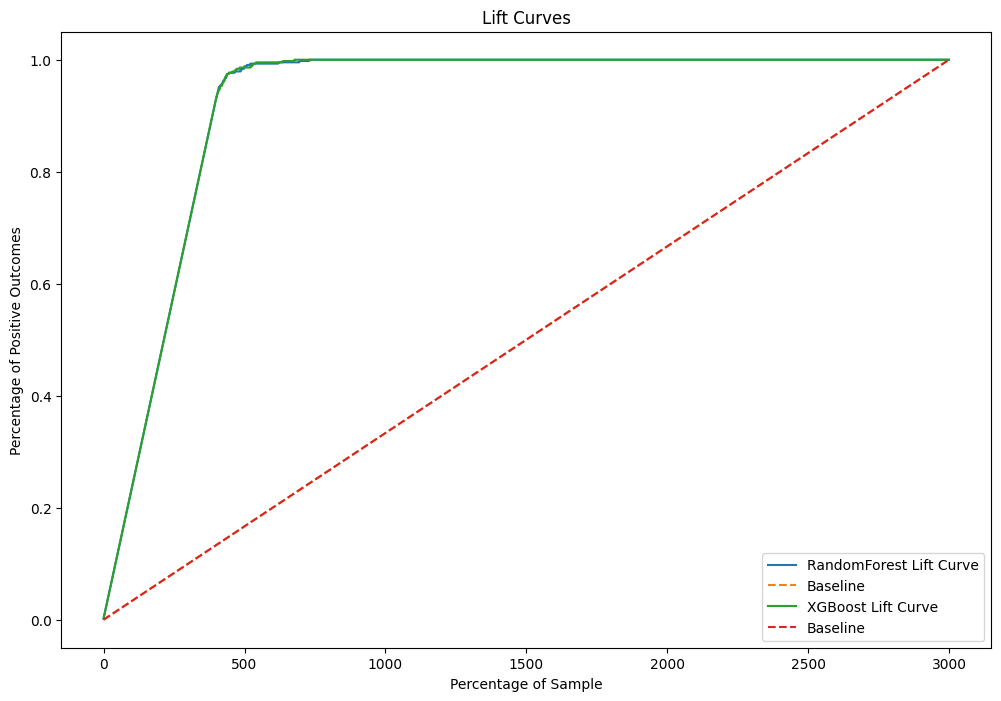

2024-11-25 15:33:06,371 - ModelTrainer - INFO - Called method save_models
2024-11-25 15:33:06,426 - ModelTrainer - INFO - Model RandomForest saved to models/RandomForest_model.joblib
2024-11-25 15:33:06,433 - ModelTrainer - INFO - Model XGBoost saved to models/XGBoost_model.joblib
2024-11-25 15:33:06,433 - ModelTrainer - INFO - Called method get_best_model
2024-11-25 15:33:06,434 - root - INFO - Model training and evaluation - elapsed time: 6.76s



Best performing model: XGBoost


In [21]:
with BlockTimer("Model training and evaluation"):
    trainer = ModelTrainer(X_train, X_test, y_train, y_test)
    trainer.train_models()
    trainer.print_results()
    trainer.plot_calibration_curves()
    trainer.plot_lift_curves()
    trainer.save_models()

    best_model = trainer.get_best_model()
    print(f"\nBest performing model: {best_model}")

In [22]:
class ModelCalibrationTrainer(BaseTrainer):
    """
    A class to train, calibrate, and evaluate models with a focus on profit optimization.
    """

    def __init__(
        self,
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.Series,
        y_test: pd.Series,
        profits: pd.Series,
    ) -> None:
        """
        Initialize the ModelCalibrationTrainer with training and testing data.

        Args:
            X_train (pd.DataFrame): Training features
            X_test (pd.DataFrame): Testing features
            y_train (pd.Series): Training labels
            y_test (pd.Series): Testing labels
            profits (pd.Series): Profits for each sample
        """
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.profits = profits
        self.models = {}
        self.calibrated_models = {}
        self.results = {}
        self.logger = logging.getLogger(self.__class__.__name__)
        return None

    @staticmethod
    def get_param_distributions() -> Dict[str, Dict[str, Any]]:
        """
        Define hyperparameter search spaces for each model.

        Returns:
            Dict[str, Dict[str, Any]]: Dictionary of parameter distributions for each model
        """
        return {
            "RandomForest": {
                "n_estimators": [100, 200, 300, 400, 500],
                "max_depth": [None, 10, 20, 30, 40, 50],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
                "max_features": ["sqrt", "log2", None],
                "class_weight": ["balanced", "balanced_subsample", None],
            },
            "XGBoost": {
                "n_estimators": [100, 200, 300, 400, 500],
                "max_depth": [3, 4, 5, 6, 7, 8],
                "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
                "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
                "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
                "min_child_weight": [1, 3, 5, 7],
                "gamma": [0, 0.1, 0.2, 0.3, 0.4],
            },
        }

    @log_method_call
    @method_timer
    def train_models(self, random_state: int = 42) -> None:
        """
        Train models with hyperparameter optimization using RandomizedSearchCV.

        Args:
            random_state (int): Random state for reproducibility
        """
        try:
            param_distributions = self.get_param_distributions()
            self.models = {}
            self.best_params = {}
            
            for name, base_model in ModelTrainer.initialize_models(random_state).items():
                self.logger.info(f"Training {name} with hyperparameter optimization")
                
                search = RandomizedSearchCV(
                    estimator=base_model,
                    param_distributions=param_distributions[name],
                    n_iter=20,
                    cv=5,
                    scoring="roc_auc",
                    n_jobs=-1,
                    random_state=random_state,
                    verbose=1,
                )
                
                search.fit(self.X_train, self.y_train)
                
                self.models[name] = search.best_estimator_
                self.best_params[name] = search.best_params_
                self.logger.info(f"Best parameters for {name}: {search.best_params_}")
                self.logger.info(f"Best cross-validation score for {name}: {search.best_score_:.4f}")
            return None
        except Exception as e:
            self.logger.error("Error training models")
            raise ModelTrainingError(e) from e

    @staticmethod
    def calibrate_model(
        model: BaseEstimator, X_train: pd.DataFrame, y_train: pd.Series, cv: int = 5
    ) -> BaseEstimator:
        """
        Calibrate a single model using CalibratedClassifierCV.

        Args:
            model (BaseEstimator): The model to calibrate
            X_train (pd.DataFrame): Training features
            y_train (pd.Series): Training labels
            cv (int): Number of cross-validation folds for calibration

        Returns:
            BaseEstimator: Calibrated model
        """
        calibrated_model = CalibratedClassifierCV(model, cv=cv, method="isotonic")
        calibrated_model.fit(X_train, y_train)
        return calibrated_model

    @log_method_call
    @method_timer
    def calibrate_models(self, cv: int = 5) -> None:
        """
        Calibrate all trained models using CalibratedClassifierCV.

        Args:
            cv (int): Number of cross-validation folds for calibration
        """
        for name, model in self.models.items():
            calibrated_model = self.calibrate_model(
                model, self.X_train, self.y_train, cv=cv
            )
            self.calibrated_models[name] = calibrated_model
            self.results[name] = self._evaluate_model(calibrated_model)
        return None

    @log_method_call
    @method_timer
    def _evaluate_model(self, model: BaseEstimator) -> ModelEvaluationResult:
        """
        Evaluate a calibrated model and return performance metrics.

        Args:
            model (BaseEstimator): Calibrated model

        Returns:
            Dict[str, Any]: Dictionary containing evaluation metrics
        """
        try:
            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]
            expected_profit = y_pred_proba * self.profits

            return {
                "classification_report": classification_report(self.y_test, y_pred),
                "roc_auc_score": roc_auc_score(self.y_test, y_pred_proba),
                "brier_score": brier_score_loss(self.y_test, y_pred_proba),
                "expected_profit": expected_profit.sum(),
                "y_pred": y_pred,
                "y_pred_proba": y_pred_proba,
            }
        except Exception as e:
            self.logger.error("Error evaluating model")
            raise ModelEvaluationError(e) from e

    @log_method_call
    def print_results(self) -> None:
        """
        Print results for calibrated models.
        """
        for name, result in self.results.items():
            print(f"\n--- Calibrated {name} Results ---")
            print(f"Best Parameters: {self.best_params[name]}")
            print("\nTest Set Performance:")
            print(result["classification_report"])
            print(f"ROC AUC Score: {result['roc_auc_score']:.4f}")
            print(f"Brier Score: {result['brier_score']:.4f}")
            print(f"Expected Profit: ${result['expected_profit']:.2f}")

    @log_method_call
    def plot_lift_curves(self):
        """
        Plot lift curves for all trained models.
        """
        plt.figure(figsize=(12, 8))
        for name, result in self.results.items():
            self._plot_single_lift_curve(self.y_test, result["y_pred_proba"], name)
        plt.title("Lift Curves")
        plt.legend()
        plt.show()

    @staticmethod
    def _plot_single_lift_curve(
        y_true: np.ndarray, y_scores: np.ndarray, model_name: str
    ):
        """
        Plot a lift curve for a single model.

        Args:
            y_true (np.ndarray): True labels
            y_scores (np.ndarray): Predicted probabilities
            model_name (str): Name of the model for the legend
        """
        data = pd.DataFrame({"y_true": y_true, "y_scores": y_scores})
        data.sort_values("y_scores", ascending=False, inplace=True)

        data["cum_true"] = data["y_true"].cumsum()
        data["lift"] = data["cum_true"] / data["y_true"].sum()
        data["baseline"] = np.arange(1, len(data) + 1) / len(data)

        plt.plot(data["lift"].values, label=f"{model_name} Lift Curve")
        plt.plot(data["baseline"].values, label="Baseline", linestyle="--")
        plt.xlabel("Percentage of Sample")
        plt.ylabel("Percentage of Positive Outcomes")

    @log_method_call
    def plot_calibration_curves(self) -> None:
        """
        Plot calibration curves for all calibrated models.
        """
        plt.figure(figsize=(12, 8))
        for name, model in self.calibrated_models.items():
            CalibrationDisplay.from_estimator(
                model, self.X_test, self.y_test, n_bins=10, name=f"Calibrated {name}"
            )
        plt.title("Calibration Curves")
        plt.legend()
        plt.show()

    @log_method_call
    def plot_profit_curves(self) -> None:
        """
        Plot profit curves for all calibrated models.
        """
        plt.figure(figsize=(12, 8))
        for name, result in self.results.items():
            self._plot_single_profit_curve(
                self.y_test, result["y_pred_proba"], self.profits, name
            )
        plt.title("Profit Curves")
        plt.legend()
        plt.grid(True)
        plt.show()
        return None

    @staticmethod
    def _plot_single_profit_curve(
        y_true: np.ndarray,
        y_scores: np.ndarray,
        profits: np.ndarray,
        model_name: str,
    ) -> None:
        """
        Plot a profit curve for a single model.

        Args:
            y_true (np.ndarray): True labels
            y_scores (np.ndarray): Predicted probabilities
            profits (np.ndarray): Profits for each sample
            model_name (str): Name of the model for the legend
        """
        data = pd.DataFrame(
            {"y_true": y_true, "y_scores": y_scores, "profit": profits}
        )
        data.sort_values("y_scores", ascending=False, inplace=True)

        data["cum_profit"] = (data["y_true"] * data["profit"]).cumsum()
        data["percentage"] = np.arange(1, len(data) + 1) / len(data)
        total_possible_profit = (data["y_true"] * data["profit"]).sum()

        plt.plot(
            data["percentage"],
            data["cum_profit"] / total_possible_profit,
            label=f"{model_name} Profit Curve",
        )

        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Baseline")

        plt.xlabel("Percentage of Sample")
        plt.ylabel("Percentage of Total Possible Profit")
        plt.title("Cumulative Profit Curve")
        return None

    @log_method_call
    def get_best_model(self, metric: str = "expected_profit") -> str:
        """
        Get the name of the best performing calibrated model based on a specified metric.

        Args:
            metric (str): Metric to use for comparison (default is 'expected_profit')

        Returns:
            str: Name of the best performing calibrated model
        """
        return max(self.results, key=lambda x: self.results[x][metric])

    @log_method_call
    def save_models(self, directory: str = "models") -> None:
        """
        Saves each model in the `models` dictionary to the specified directory using `joblib`.
        The models are saved with filenames in the format `{model_name}_model.joblib`.

        Args:
            directory (str, optional): The directory where models will be saved. Defaults to `"models"`.

        Returns:
            None
        """
        directory_path = Path(directory)
        directory_path.mkdir(parents=True, exist_ok=True)
        for name, model in self.models.items():
            filename = directory_path / f"{name}_model.joblib"
            joblib.dump(model, filename)
            self.logger.info(f"Model {name} saved to {filename}")
        return None

    @log_method_call
    def load_models(self, directory: str = "models") -> None:
        """
        Loads models from the specified directory into the `models` dictionary.
        It expects model files with filenames in the format `{model_name}_model.joblib`.

        Args:
            directory (str, optional): The directory from which models will be loaded. Defaults to `"models"`.

        Returns:
            None
        """
        directory_path = Path(directory)
        self.models = {}
        for filepath in directory_path.glob("*_model.joblib"):
            name = filepath.stem.replace("_model", "")
            model = joblib.load(filepath)
            self.models[name] = model
            self.logger.info(f"Model {name} loaded from {filepath}")
        return None

    @log_method_call
    def run_all(self) -> None:
        """
        Run all steps: train models, calibrate models, print results, and plot curves.
        """
        self.train_models()
        self.calibrate_models()
        self.print_results()
        self.plot_calibration_curves()
        self.plot_lift_curves()
        self.plot_profit_curves()
        self.save_models()
        best_model = self.get_best_model()
        print(f"\nBest calibrated model based on expected profit: {best_model}")
        return None

2024-11-25 15:33:06,513 - root - INFO - Starting Model training, calibration and evaluation
2024-11-25 15:33:06,515 - ModelCalibrationTrainer - INFO - Called method train_models
2024-11-25 15:33:06,515 - ModelCalibrationTrainer - INFO - Training RandomForest with hyperparameter optimization


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2024-11-25 15:33:10,304 - ModelCalibrationTrainer - INFO - Best parameters for RandomForest: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': None}
2024-11-25 15:33:10,304 - ModelCalibrationTrainer - INFO - Best cross-validation score for RandomForest: 0.9988
2024-11-25 15:33:10,305 - ModelCalibrationTrainer - INFO - Training XGBoost with hyperparameter optimization


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2024-11-25 15:33:10,989 - ModelCalibrationTrainer - INFO - Best parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 1.0}
2024-11-25 15:33:10,989 - ModelCalibrationTrainer - INFO - Best cross-validation score for XGBoost: 0.9988
2024-11-25 15:33:10,989 - ModelCalibrationTrainer - INFO - Method train_models executed in 4.47s
2024-11-25 15:33:10,990 - ModelCalibrationTrainer - INFO - Called method calibrate_models
2024-11-25 15:33:12,369 - ModelCalibrationTrainer - INFO - Called method _evaluate_model
2024-11-25 15:33:12,760 - ModelCalibrationTrainer - INFO - Method _evaluate_model executed in 0.39s
2024-11-25 15:33:13,434 - ModelCalibrationTrainer - INFO - Called method _evaluate_model
2024-11-25 15:33:13,458 - ModelCalibrationTrainer - INFO - Method _evaluate_model executed in 0.02s
2024-11-25 15:33:13,459 - ModelCalibrationTrainer - INFO - Method calibrate_models executed in 2.47


--- Calibrated RandomForest Results ---
Best Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': None}

Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2570
           1       0.93      0.98      0.95       430

    accuracy                           0.99      3000
   macro avg       0.96      0.98      0.97      3000
weighted avg       0.99      0.99      0.99      3000

ROC AUC Score: 0.9987
Brier Score: 0.0120
Expected Profit: $1894952.16

--- Calibrated XGBoost Results ---
Best Parameters: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 1.0}

Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2570
           1       0.93      0.98      0.95       430

    acc

<Figure size 1200x800 with 0 Axes>

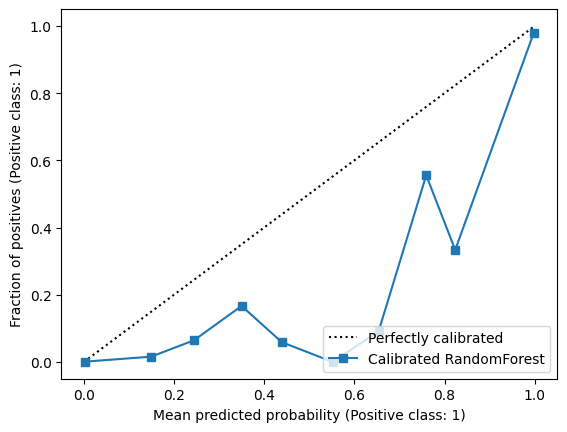

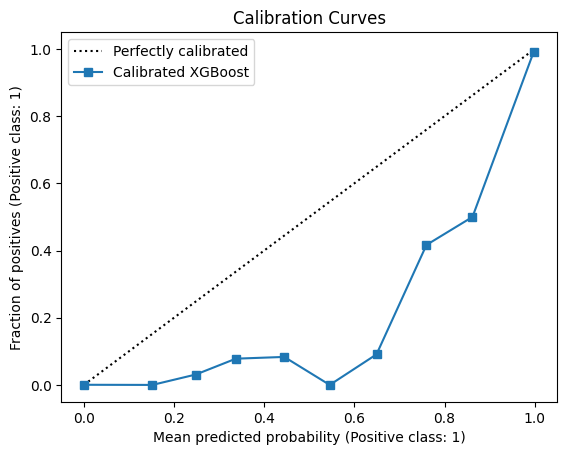

2024-11-25 15:33:13,746 - ModelCalibrationTrainer - INFO - Called method plot_lift_curves


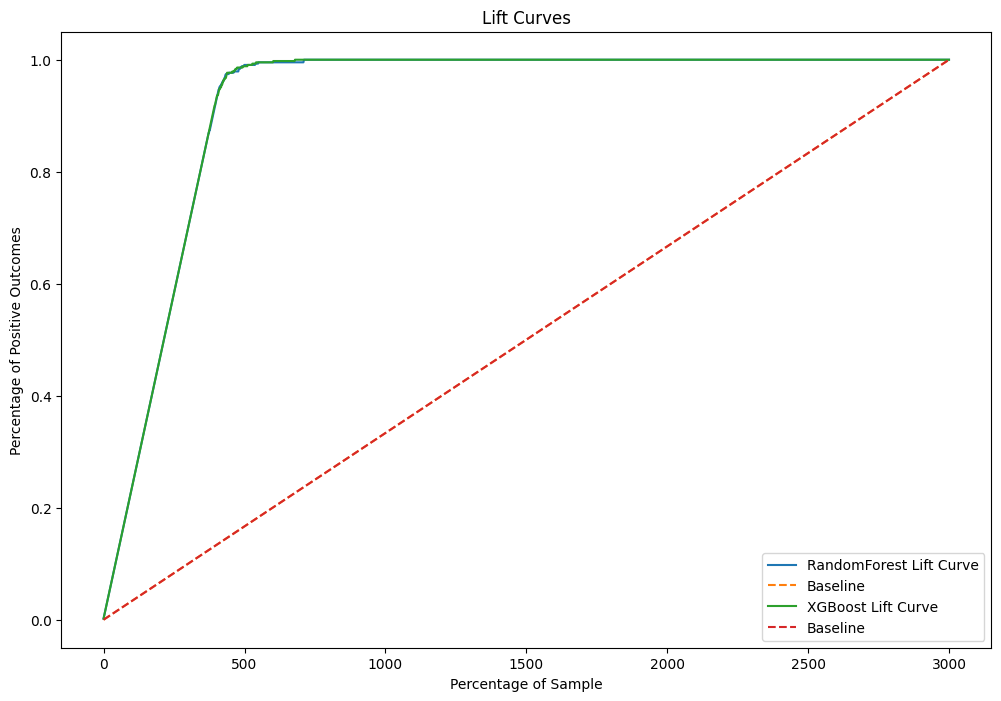

2024-11-25 15:33:13,821 - ModelCalibrationTrainer - INFO - Called method plot_profit_curves


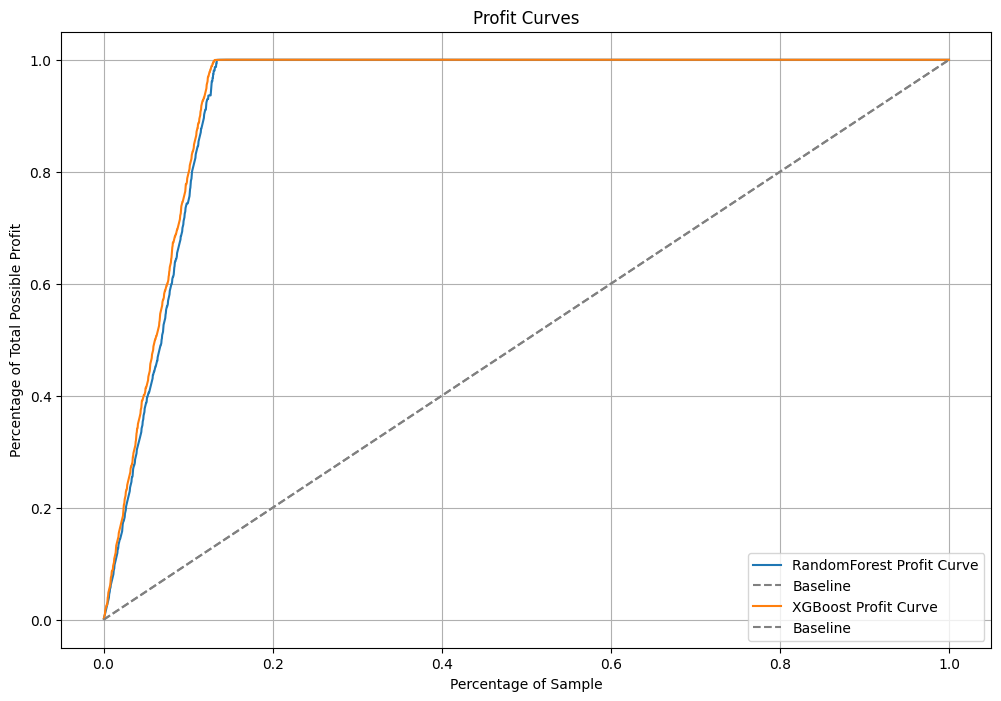

2024-11-25 15:33:13,893 - ModelCalibrationTrainer - INFO - Called method save_models
2024-11-25 15:33:13,941 - ModelCalibrationTrainer - INFO - Model RandomForest saved to models/RandomForest_model.joblib
2024-11-25 15:33:13,943 - ModelCalibrationTrainer - INFO - Model XGBoost saved to models/XGBoost_model.joblib
2024-11-25 15:33:13,944 - ModelCalibrationTrainer - INFO - Called method get_best_model
2024-11-25 15:33:13,944 - root - INFO - Model training, calibration and evaluation - elapsed time: 7.43s



Best calibrated model based on expected profit: RandomForest


In [23]:
with BlockTimer("Model training, calibration and evaluation"):
    profits_test = data.loc[X_test.index, "Profit"]
    calibration_trainer = ModelCalibrationTrainer(
        X_train, X_test, y_train, y_test, profits_test
    )
    calibration_trainer.train_models()
    calibration_trainer.calibrate_models()
    calibration_trainer.print_results()
    calibration_trainer.plot_calibration_curves()
    calibration_trainer.plot_lift_curves()
    calibration_trainer.plot_profit_curves()
    calibration_trainer.save_models()

    best_model = calibration_trainer.get_best_model()
    print(f"\nBest calibrated model based on expected profit: {best_model}")